In [1]:
%matplotlib inline

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from lxml import html, etree
import time
import json
import datetime


In [13]:
## daily prices
bit_price_d = pd.read_excel("bitcoin_data/btc_close_daily.xlsx")
eth_price_d = pd.read_excel("bitcoin_data/eth_close_daily.xlsx")

eth_price_d.head()

,Date_text,Month,Month day,day,year,Date,Open,High,Low,Close,Volume,Market Cap
0,"Apr 01, 2018",Apr,4.0,1.0,2018.0,2018-04-01,397.25,400.53,363.81,379.61,1.256930e+09,39144700000
1,"Mar 31, 2018",Mar,3.0,31.0,2018.0,2018-03-31,395.00,418.47,392.95,396.46,1.323920e+09,38914900000
2,"Mar 30, 2018",Mar,3.0,30.0,2018.0,2018-03-30,385.91,409.93,368.63,394.65,1.878130e+09,38010600000
3,"Mar 29, 2018",Mar,3.0,29.0,2018.0,2018-03-29,448.08,450.81,385.81,385.97,1.970230e+09,44125000000
4,"Mar 28, 2018",Mar,3.0,28.0,2018.0,2018-03-28,450.29,466.21,444.86,446.28,1.514180e+09,44334000000


In [2]:
## minute prices
##

bit_price = pd.read_csv('bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv')
bit_price.columns = [x.lower() for x in bit_price.columns.values]
bit_price['date_time'] = bit_price['timestamp'].map(lambda x: datetime.datetime.fromtimestamp(x)) ## MSC timezone
bit_price.head()

,timestamp,open,high,low,close,volume_(btc),volume_(currency),weighted_price,date_time
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:52:00
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:53:00
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:54:00
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:55:00
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:56:00


#### Graphs

Bitcoin price evalution 

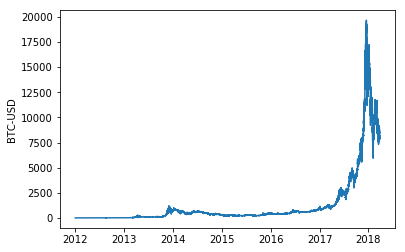

In [20]:
fig, ax = plt.subplots()
ax.plot(bit_price['date_time'],bit_price['open'])
ax.set_ylabel('BTC-USD')

plt.show()

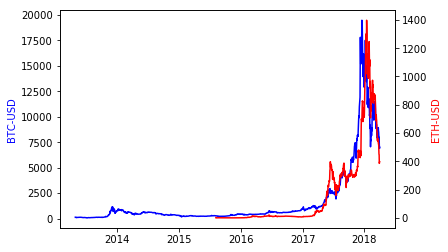

In [18]:
fig, ax1 = plt.subplots()

ax1.plot(bit_price_d['Date'],bit_price_d['Close'],'b')
ax1.set_ylabel('BTC-USD',color='b')


ax2 = ax1.twinx()
ax2.plot(eth_price_d['Date'],eth_price_d['Clo'],'r')
ax2.set_ylabel('ETH-USD', color='r')
plt.show()